# M5 Forecasting - Accuracy

![M5 Forecasting - Accuracy](M5forecast.png)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/m5-forecasting-transformer/submission.csv
/kaggle/input/m5-forecasting-transformer/reports/eval_results.json
/kaggle/input/m5-forecasting-transformer/reports/figures/eval_valid.png
/kaggle/input/m5-forecasting-transformer/reports/figures/eval_train.png
/kaggle/input/m5-forecasting-transformer/reports/figures/pred_test.png
/kaggle/input/m5-forecasting-transformer/reports/figures/eval_valid/dept_id_HOUSEHOLD_1.png
/kaggle/input/m5-forecasting-transformer/reports/figures/eval_valid/store_id_CA_1.png
/kaggle/input/m5-forecasting-transformer/reports/figures/eval_valid/dept_id_HOBBIES_1.png
/kaggle/input/m5-forecasting-transformer/reports/figures/eval_valid/dept_id_FOODS_1.png
/kaggle/input/m5-forecasting-transformer/reports/figures/eval_valid/dept_id_HOUSEHOLD_2.png
/kaggle/input/m5-forecasting-transformer/reports/figures/eval_valid/store_id_CA_2.png
/kaggle/input/m5-forecasting-transformer/reports/figures/eval_valid/dept_id_FOODS_2.png
/kaggle/input/m5-forecasting-transformer

In [2]:
from distutils.dir_util import copy_tree

copy_tree(
    src="/kaggle/input/m5-forecasting-transformer/src",
    dst="/kaggle/working/src"
)


['/kaggle/working/src/utils/utils.py',
 '/kaggle/working/src/utils/__init__.py',
 '/kaggle/working/src/features/build_dataset.py',
 '/kaggle/working/src/features/build_features.py',
 '/kaggle/working/src/features/.gitkeep',
 '/kaggle/working/src/features/__init__.py',
 '/kaggle/working/src/models/predict_model.py',
 '/kaggle/working/src/models/setting_model.py',
 '/kaggle/working/src/models/loss.py',
 '/kaggle/working/src/models/architecture.py',
 '/kaggle/working/src/models/.gitkeep',
 '/kaggle/working/src/models/eval_model.py',
 '/kaggle/working/src/models/__init__.py',
 '/kaggle/working/src/models/train_model.py',
 '/kaggle/working/src/data/.gitkeep',
 '/kaggle/working/src/data/__init__.py',
 '/kaggle/working/src/data/make_dataset.py',
 '/kaggle/working/src/__init__.py',
 '/kaggle/working/src/visualization/.gitkeep',
 '/kaggle/working/src/visualization/visualize.py',
 '/kaggle/working/src/visualization/__init__.py']

# import modules

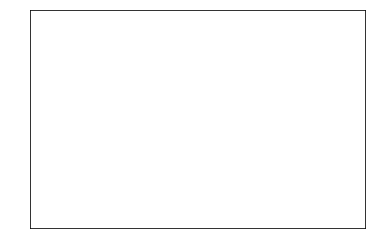

In [3]:
import os
import sys 
import gc 
import warnings 
import random
from pathlib import Path

import numpy as np
import torch 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.getcwd())

seed = 0
random.seed(seed)  
np.random.seed(seed)  
torch.manual_seed(seed) 

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 5000)

%matplotlib inline
plt.tick_params(colors='white')
sns.set_style("darkgrid")

warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', pd.core.common.SettingWithCopyWarning)
warnings.simplefilter('ignore', RuntimeWarning)


In [4]:
from src.data.make_dataset import (
    read_dataset, 
    get_date_cols, 
    merge_dataset
)
from src.features.build_dataset import (
    TSdatasets, 
    setting_dataloader
)

from src.features.build_features import (
    select_activate_items, 
    complement_missing,
    add_base_features,
    feature_enginearing
)
from src.models.eval_model import (
    WRMSSEEvaluator, 
    root_mean_squared_error, 
    eval_quantity
)
from src.models.setting_model import (
    AdaBound, 
    GradualWarmupScheduler
)
from src.models.architecture import TransformerModel
from src.models.loss import RMSELoss
from src.models.setting_model import setting_model
from src.models.train_model import RecursiveModel
from src.visualization.visualize import (
    plot_sales,
    plot_lr_and_sr,
    plot_losses,
    plot_eval, 
    plot_eval_per_group,
    plot_prediction
)
from src.models.predict_model import (
    output_inverse, 
    to_submission
)


# Config

In [5]:
private_sub = False

In [6]:
model_path = '/kaggle/working/models/transformer.model'
reports_dir = '/kaggle/working/reports'
vis_dir = '/kaggle/working/reports/figures'

In [7]:
# dataset
N_IDS = 5000
# N_IDS = 30490
max_train_size = 364 * 5

test_size = 28
d_col = 'd'

# features
diff_trans = False

pow_trans = False
season_diff_interval = 0
# season_diff_interval = 28
std_trans = True
minmax_trans = False

base_cols = [
    'date', 
    'weekday', 
    'month', 
    'year', 
    'event_name_1', 
    'event_type_1', 
    'event_name_2', 
    'event_type_2', 
    'snap_CA', 
    'snap_TX', 
    'snap_WI'
]

num_cols = [
    'sell_price', 
    'is_snap'
]
sales_cat_cols = [
    'id', 
    'item_id', 
    'dept_id', 
    'cat_id', 
    'store_id', 
    'state_id'
]
cat_cols = [
    'quarter', 
    'is_weekend', 
    'part_of_month', 
    'event_name_1', 
    'event_type_1'
]

all_cat_cols = sales_cat_cols + cat_cols 

# if 0, onehot
cat_emb = {
    'id': 80,
    'item_id': 30, 
    'dept_id': 0,
    'cat_id': 0, 
    'store_id': 0, 
    'state_id': 0,
    'quarter': 0,
    'is_weekend': 0,
    'part_of_month': 0,
    'weekday': 3,
    'month': 4,
    'event_name_1': 10,
    'event_type_1':0,
    'event_name_2': 10,
    'event_type_2':0
}



In [8]:
# model
epochs = 30
batch_size = 1024//4
clipping_value = 0.5
log_interval = 1

bptt_x = 28 * 3
bptt_y = test_size
lags = [(1, 6), (7, 28 * 3)] # (tau, period)

all_lags = [lag for tau, period in lags for lag in range(tau, period+1, tau)]
t_emb = sum([lag[1] // lag[0] for lag in lags])
max_tau, max_lag  = lags[-1]

scheduled_sampling = True
src_mask = False
memory_mask = False
nhid = 2048 // 2 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 6 // 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8 // 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
# fc_dims = [128, 64]
fc_dims = []
activation = 'relu'

lr = 1e-3 # learning rate



# Read

In [9]:
sell_prices, sample_submission, calendar, sales_train = read_dataset(private_sub)

In [10]:
level_cols, train_d_cols, test_d_cols, d2F_map = get_date_cols(
    sales_train, 
    sample_submission, 
    max_train_size, 
    max_lag, 
    private_sub=private_sub
)
    

# Feature engineering

In [11]:
sales_train = sales_train.iloc[:N_IDS, :]

X = merge_dataset(
    sales_train, 
    calendar, 
    sell_prices, 
    base_cols,
    level_cols,
    train_d_cols,
    test_d_cols
)



Running... merge_dataset
0 m 40 s in merge_dataset


In [12]:
X = select_activate_items(X, train_d_cols, test_size, bptt_x, max_lag)
X = complement_missing(X)
X = add_base_features(X)


Running... select_activate_items
0 m 29 s in select_activate_items
Running... complement_missing
0 m 29 s in complement_missing
Running... add_base_features
0 m 33 s in add_base_features


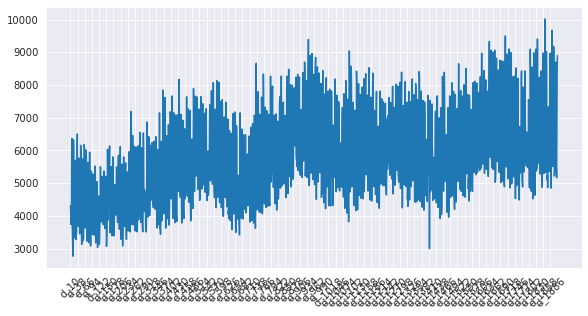

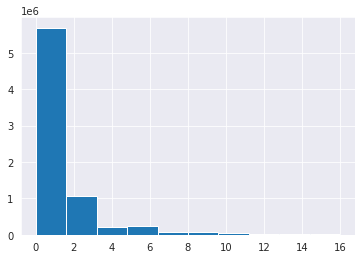

In [13]:
plot_sales(
    X.groupby('d')['sales'].sum(), 
    X['sales'], 
    train_d_cols
)

In [14]:
X, all_cat_cols, all_num_cols, list_dtrans, id_enc = feature_enginearing(
    X, 
    train_d_cols[max_lag+1:-test_size], 
    test_d_cols, 
    lags, 
    max_lag,
    sales_cat_cols,
    cat_cols,
    num_cols, 
    diff_trans,
    dtrans_map={'sales':[pow_trans, std_trans, minmax_trans, season_diff_interval], 
                'sell_price':[False, True, False, 0]}, 
    clipping_range={'sales': (0.0, 1.0), 
                    'sell_price': (0.0, 1.0)}
)

trainloader, validloader, validmaskloader, testloader = setting_dataloader(
    X, 
    train_d_cols,
    test_d_cols,
    all_num_cols,
    all_cat_cols,
    bptt_x,
    bptt_y,
    max_lag,
    test_size,
    batch_size,
)


categorical encoding...
clipping...
scaling...
lag features...
Running... setting_dataloader
1 m 1 s in setting_dataloader


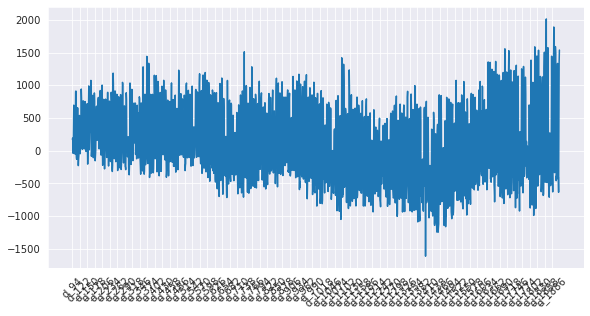

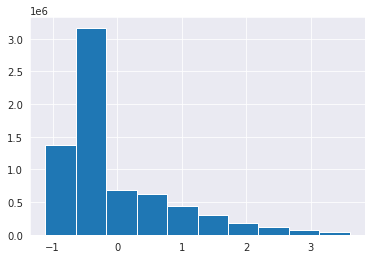

In [15]:
plot_sales(
    X.groupby(['id', 'd'])['sales'].sum().reset_index().pivot(
        index='id', columns='d', values='sales'
    ).sum(0), 
    X['sales'], 
    train_d_cols
)


# Modeling

In [16]:
model_params = dict(
    src_seq_len=bptt_x,
    d_model=len(all_num_cols),
    nhead=nhead,
    nhid=nhid,
    nlayers=nlayers,
    dropout=dropout,
    fc_dims=fc_dims,
    activation=activation,
    use_src_mask=src_mask,
    use_memory_mask=memory_mask,
)

opt_params = dict(lr=lr, weight_decay=1e-4, amsgrad=False)

lr_params = dict(T_max=epochs - (epochs // 10), eta_min=1e-5)

warmup_params = dict(multiplier=1, total_epoch=epochs // 10)

sr_params = dict(
    decay_schedules="inverse_sigmoid_decay",
    k=epochs,
    start=1.0,
    end=0.01,
    slope=0.3,
)


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:484: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


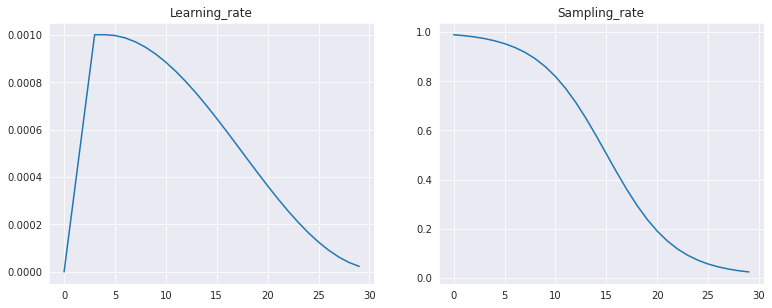

In [17]:
_, optimizer, _, lr_scheduler, sr_scheduler = setting_model(
    X,
    cat_emb,
    all_cat_cols,
    all_num_cols,
    model_params,
    opt_params,
    lr_params,
    warmup_params,
    sr_params,
)

plot_lr_and_sr(epochs, optimizer, lr_scheduler, sr_scheduler)

In [18]:
model = RecursiveModel(bptt_y, all_lags)
model.setting_model(
    *setting_model(
        X,
        cat_emb,
        all_cat_cols,
        all_num_cols,
        model_params,
        opt_params,
        lr_params,
        warmup_params,
        sr_params,
    )
)

In [19]:
model.model

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=168, out_features=168, bias=True)
        )
        (linear1): Linear(in_features=168, out_features=1024, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=1024, out_features=168, bias=True)
        (norm1): LayerNorm((168,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((168,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=168, out_features=168, bias=True)
        )
        (linear1): Linear(in_features=168, out_features=

Training...
Training until validation scores don't improve for 1 rounds
[1] 	 training's RMSELoss: 1.59645 	 valid's RMSELoss: 1.50987 	 | lr=0.00000 	 sr=0.98912
[2] 	 training's RMSELoss: 0.97871 	 valid's RMSELoss: 1.01401 	 | lr=0.00033 	 sr=0.98537
[3] 	 training's RMSELoss: 0.93022 	 valid's RMSELoss: 1.00516 	 | lr=0.00067 	 sr=0.98036
[4] 	 training's RMSELoss: 0.92775 	 valid's RMSELoss: 1.01295 	 | lr=0.00100 	 sr=0.97367
[5] 	 training's RMSELoss: 0.92537 	 valid's RMSELoss: 1.00746 	 | lr=0.00100 	 sr=0.96478
[6] 	 training's RMSELoss: 0.92439 	 valid's RMSELoss: 1.00357 	 | lr=0.00100 	 sr=0.95305
[7] 	 training's RMSELoss: 0.92393 	 valid's RMSELoss: 0.99902 	 | lr=0.00099 	 sr=0.93766
[8] 	 training's RMSELoss: 0.92408 	 valid's RMSELoss: 1.00385 	 | lr=0.00097 	 sr=0.91766
[9] 	 training's RMSELoss: 0.92416 	 valid's RMSELoss: 1.00350 	 | lr=0.00095 	 sr=0.89199
[10] 	 training's RMSELoss: 0.92449 	 valid's RMSELoss: 0.99719 	 | lr=0.00092 	 sr=0.85957
[11] 	 training's

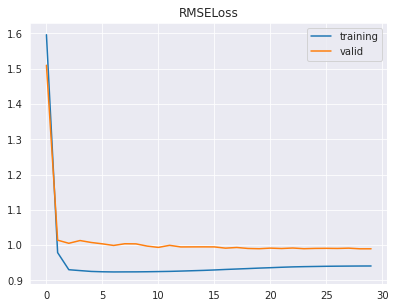

In [20]:
print('Training...')
losses = model.train(model_path, trainloader, validloader, epochs)

del trainloader
gc.collect()

plot_losses(model, losses)

In [21]:
pred_idx = testloader.dataset.en_cat_i[:, 0, 0].argsort()
train_pred_d_cols = train_d_cols[-test_size*2:-test_size]
valid_pred_d_cols = train_d_cols[-test_size:]

trainmaskset = TSdatasets(
    X, 
    train_d_cols[-((test_size * 2) + max_lag):-test_size], 
    all_num_cols, 
    all_cat_cols, 
    bptt_x, 
    bptt_y, 
    max_lag,
    mask=True
)
trainmaskloader = torch.utils.data.DataLoader(
    trainmaskset, batch_size=batch_size, shuffle=False
)

print('Predicting...')

output_train = output_inverse(
    model.predict(trainmaskloader)[pred_idx], 
    list_dtrans[0], 
    id_enc.classes_, 
    train_pred_d_cols,
    diff_trans,
    sales_train.loc[
        :N_IDS, train_d_cols[-test_size*2-1]].values,    
)

output_valid = output_inverse(
    model.predict(validmaskloader)[pred_idx], 
    list_dtrans[0], 
    id_enc.classes_, 
    valid_pred_d_cols,
    diff_trans,
    sales_train.loc[
        :N_IDS, train_d_cols[-test_size-1]].values
)

output_test = output_inverse(
    model.predict(testloader)[pred_idx], 
    list_dtrans[0], 
    id_enc.classes_, 
    test_d_cols,
    diff_trans,
    sales_train.loc[
        :N_IDS, train_d_cols[-1]].values
)


output_train = pd.concat(
    [sales_train[level_cols].set_index('id'), output_train], 
    axis=1
)

output_valid = pd.concat(
    [sales_train[level_cols].set_index('id'), output_valid], 
    axis=1
)

true_train = sales_train[level_cols + train_pred_d_cols[-test_size:]].set_index('id')
true_valid = sales_train[level_cols + valid_pred_d_cols].set_index('id')


  0%|          | 0/20 [00:00<?, ?it/s]

Predicting...


100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


# Evaluation

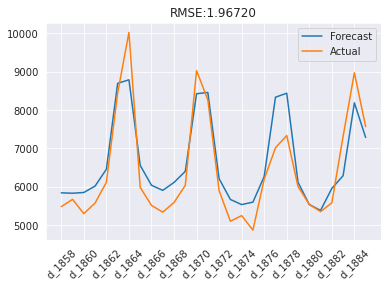

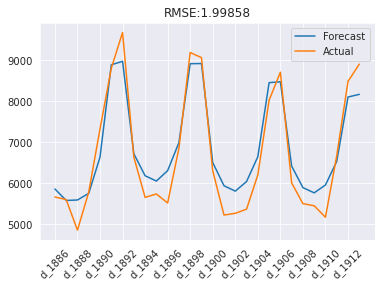

In [22]:
plot_eval(
    Path(vis_dir, 'eval_train'), 
    output_train[train_pred_d_cols[-test_size:]], 
    true_train[train_pred_d_cols[-test_size:]]
)
plot_eval(
    Path(vis_dir, 'eval_valid'), 
    output_valid[valid_pred_d_cols], 
    true_valid[valid_pred_d_cols]
)

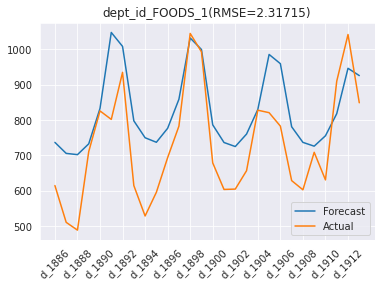

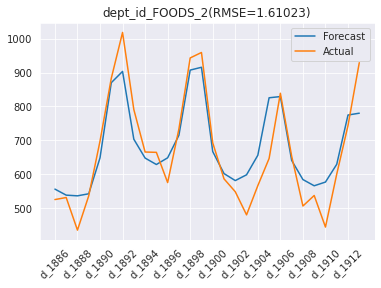

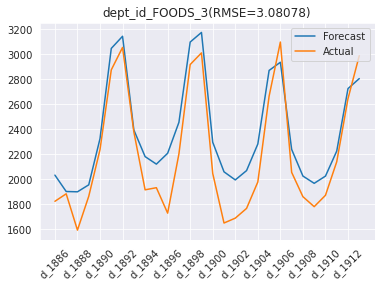

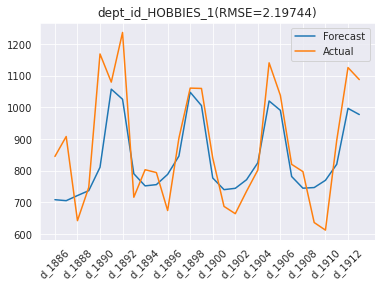

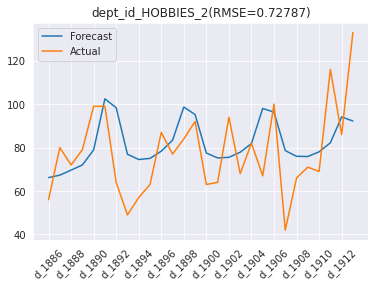

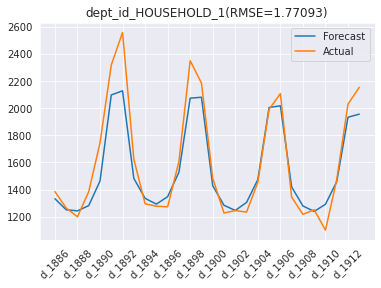

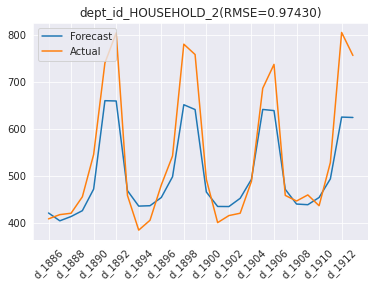

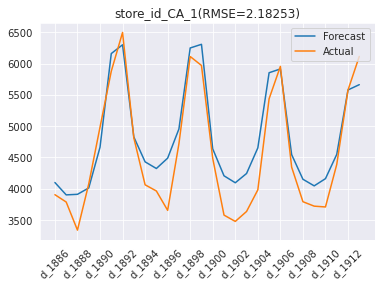

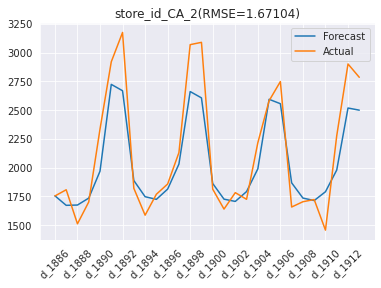

In [23]:
plot_eval_per_group(
    Path(vis_dir, 'eval_valid'), output_valid, true_valid, 'dept_id', valid_pred_d_cols
)
plot_eval_per_group(
    Path(vis_dir, 'eval_valid'), output_valid, true_valid, 'store_id', valid_pred_d_cols
)

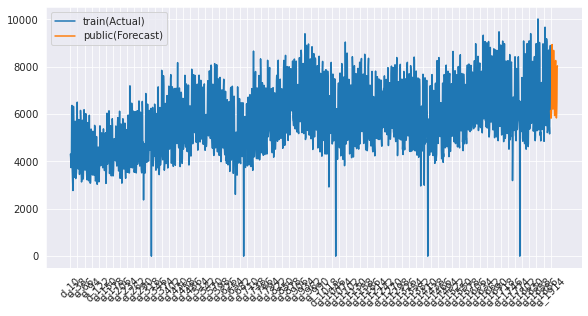

In [24]:
plot_prediction(
    Path(vis_dir, 'pred_test'), 
    sales_train.loc[: N_IDS - 1, train_d_cols], 
    output_test
)

In [25]:
eval_quantity(
    Path(reports_dir, 'eval_results.json'),
    output_valid,
    sales_train,
    calendar,
    sell_prices,
    valid_pred_d_cols,
)


100%|██████████| 11141/11141 [00:01<00:00, 7849.78it/s]


RMSE: 1.9985764026641846
WRMSSE_validation: 0.5764785393621153


# Submission

In [26]:
my_submission = to_submission(
    output_test,
    sales_train,
    sample_submission,
    test_d_cols,
    d2F_map,
    private_sub=private_sub,

)

my_submission.to_csv("submission.csv")

In [27]:
my_submission

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,0.692673,0.787308,0.778633,0.789844,0.813770,1.015516,1.031135,0.774322,0.788198,0.774205,0.811668,0.871533,1.094050,0.843443,0.757962,0.754856,0.747040,0.820210,0.852762,1.020754,0.987841,0.773533,0.760400,0.769203,0.814664,0.836876,1.000573,0.998871
HOBBIES_1_002_CA_1_validation,0.241017,0.218383,0.193080,0.210065,0.190342,0.228323,0.270568,0.224546,0.201235,0.201774,0.211884,0.211406,0.273068,0.167588,0.197265,0.192464,0.185814,0.206206,0.197707,0.246116,0.242743,0.198012,0.178946,0.186232,0.200981,0.199690,0.244269,0.242590
HOBBIES_1_003_CA_1_validation,0.485283,0.415913,0.401856,0.469879,0.543374,0.627342,0.678218,0.444171,0.422103,0.445775,0.439867,0.514027,0.645593,0.493811,0.438868,0.432926,0.440138,0.452956,0.501804,0.604445,0.624109,0.461558,0.440029,0.439017,0.453849,0.502262,0.611225,0.604117
HOBBIES_1_004_CA_1_validation,1.751840,1.554957,1.555558,1.755609,1.794843,2.171630,2.739897,1.908599,1.690441,1.653977,1.649790,1.850689,2.434758,2.183879,1.860585,1.639024,1.597154,1.681658,1.849633,2.331602,2.571494,1.904987,1.664239,1.624709,1.693030,1.902861,2.341443,2.526383
HOBBIES_1_005_CA_1_validation,1.149779,1.125060,1.196452,1.203368,1.274628,1.468759,1.651222,1.256576,1.180916,1.150916,1.118475,1.211017,1.490509,1.265208,1.208606,1.143977,1.101242,1.134533,1.188001,1.373362,1.489527,1.154938,1.087167,1.075136,1.114466,1.180723,1.397416,1.443194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FOODS_3_824_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FOODS_3_825_WI_3_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
